In [1]:
"""
This Jupyter notebook serves as the main file for the project, allowing for step-by-step visualization
of the data and the application of the various functions defined in the other modules.
"""

'\nThis Jupyter notebook serves as the main file for the project, allowing for step-by-step visualization\nof the data and the application of the various functions defined in the other modules.\n'

In [2]:
import os
import math
import numpy as np
import pandas as pd

from PIL import Image

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from astropy.constants import L_sun, R_sun, R_earth, c, L_sun, au
from astropy.coordinates import SkyCoord

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.time import Time
from astropy.visualization import astropy_mpl_style
from astropy import units as u

import lightkurve as lk

from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry

from scipy.interpolate import interp1d

from skimage import io, filters, measure, util
from skimage.color import rgb2gray
from skimage.draw import circle_perimeter, ellipse
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate

from uncertainties import ufloat, unumpy

plt.style.use(astropy_mpl_style)

### Handling data

In [3]:
def im_brightness(data_array):
    """
    Computes the brightness of an image given as a 3D numpy array of RGB color values.
    """
    
    #brightness = 0.2126*arr[:,:,0] + 0.7152*arr[:,:,1] + 0.0722*arr[:,:,2] # Convert RGB to brightness plot
    #return brightness
    
    return data_array[:,:,0] + data_array[:,:,1] + data_array[:,:,2]

In [4]:
def dark_frame_mean(path):
    """
    Computes the mean dark frame from a directory of dark frames.
    """
    df = os.listdir(path)
    df_array = np.zeros((len(df), 484, 648, 3)) # RBG images so each image has 3 sets of data
 
    for i in range(len(df)):
        df_array[i,:,:,:] = Image.open(path + '/' + df[i])
    
    out_dark = np.mean(df_array, axis=0)
                        
    return im_brightness(out_dark)

In [5]:
def find_outliers(data):
    """
    Identifies and returns the indices of the outliers in a given dataset using the interquartile range (IQR).
    """
    # Compute the first and third quartiles of the data
    q1, q3 = np.percentile(data, [25, 75])

    # Compute the interquartile range (IQR)
    iqr = q3 - q1

    # Define the lower and upper bounds for outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Identify the indices of the data points that are outliers
    outlier_indices = np.where((data < lower_bound) | (data > upper_bound))[0]

    # Return the outlier indices
    return outlier_indices

In [6]:
def moving_average(data, window):
    """
    Compute the moving average of a time series data.

    """
    weights = np.repeat(1.0, window)/window
    ma = np.convolve(data, weights, 'valid')
    return ma

In [7]:
def plot_light_curve(data, exposure_time, title, window_size = None, replace_outliers = False, outliers = None):
    """
    Plots a light curve given time and flux data. Can also include optional moving average smoothing and outlier removal.
    """
    
    data_copy = data.copy()
    data_copy[outliers] = np.nan
    
    num_points = len(data)
    time = np.arange(0, num_points * exposure_time, exposure_time)
    
    # Plot light curve
    fig, ax = plt.subplots()
    
    if outliers is not None:
        data_copy = data.copy()
        data_copy[outliers] = np.nan
        
        ax.plot(time, data_copy * (4.8 * 10 ** -14))
        ax.scatter(time, data_copy * (4.8 * 10 ** -14), s = 10, label = 'Measurements')
        
        if replace_outliers:
            # Replace outlier values with moving average values
            if window_size is not None:
                # Compute moving average
                ma_data = moving_average(data, window_size)
                data[outliers] = ma_data[outliers]
                                
                ma_predictions = ma_data[outliers] * (4.8 * 10 ** -14)
                print('The moving average suggest to replace the non-boundary outliers by:')
                print(ma_data[outliers])
            
                # Highlight outlier values in red
                ax.plot(time[outliers], data[outliers] * (4.8 * 10 ** -14), '.', markersize = 6, color = 'red', label = 'Replaced Outliers')
            else:
                print("Please provide a valid window size for moving average smoothing.")
                
    else:
        ax.plot(time, data * (4.8 * 10 ** -14))
        ax.scatter(time, data * (4.8 * 10 ** -14), s = 10, label = 'Measurements')
    
    # Label and display plot
    ax.set_xlabel(r'Time ($s$)')
    ax.set_ylabel(r'Luminosity ($W$)')
    ax.set_title(title)
    ax.legend()
    plt.show()

### Image segmentation to locate and characterise the star

In [8]:
def im_segmentation(data_array):
    """
    Performs image segmentation on an input RGB image to identify individual objects.
    """
        
    # Convert the image to grayscale
    image_gray = rgb2gray(data_array)

    # Compute the threshold value for object detection
    threshold = filters.threshold_otsu(image_gray)

    # Perform image segmentation to identify the individual objects in the image
    label_image = label(image_gray >= threshold)
    
    # Uncomment to plot image segmentation
    #plt.imshow(label_image, origin='lower')

    # Extract the properties of the objects detected in the image
    props = regionprops_table(label_image, properties = ('centroid',
                                                 'orientation',
                                                 'axis_major_length',
                                                 'axis_minor_length'))
    
    df = pd.DataFrame(props)
    
    return df

### Ring Background Photometry

In [9]:
def RBP_plot(brightness_data, segmentation, plot_title, fig = None, ax = None):
    """
    Plots the results of ring background photometry for an input image.
    """

    # Define the circular aperture
    position = (segmentation.loc[0, 'centroid-1'], segmentation.loc[0, 'centroid-0'])
    aperture_radius = (segmentation.loc[0, 'axis_major_length'] + segmentation.loc[0, 'axis_minor_length']) / 4
    aperture = CircularAperture(position, aperture_radius)

    if fig is None and ax is None:
        fig, ax = plt.subplots()

    # Plot the image
    im = ax.imshow(brightness_data, cmap = cm.inferno, origin = 'lower')

    # Draw the aperture and annulus on the axis
    for radius, color in [(aperture_radius, 'darkorange'),
                          (aperture_radius + 5.0, 'cyan'),
                          (aperture_radius + 10.0, 'cyan')]:
        circle = plt.Circle(position, radius, color = color, fill = False)
        ax.add_artist(circle)

    # Add a color bar
    # Add a colorbar to the plot
    cbar = fig.colorbar(im, ax = ax)

    plt.title(plot_title)
    # Show the plot
    plt.show()
    

In [10]:
def RBP_flux(brightness_data, segmentation):
    """
    Performs the ring background photometry on the input image data and segmentation
    """
    
    # Define the circular aperture
    position = (segmentation.loc[0, 'centroid-1'], segmentation.loc[0, 'centroid-0'])
    aperture_radius = (segmentation.loc[0, 'axis_major_length'] + segmentation.loc[0, 'axis_minor_length']) / 4
    aperture = CircularAperture(position, aperture_radius)

    # Extract the pixel values within the aperture
    phot_table = aperture_photometry(brightness_data, aperture)

    # Compute the total flux within the aperture
    flux = phot_table['aperture_sum'][0]

    # Compute the mean background level within an annulus around the star
    inner_annulus_radius = aperture_radius + 5.0
    outer_annulus_radius = aperture_radius + 10.0
    annulus_aperture = CircularAnnulus(position, inner_annulus_radius, outer_annulus_radius)
    annulus_masks = annulus_aperture.to_mask(method = 'center')
    annulus_data = annulus_masks.multiply(brightness_data)
    background_mean = annulus_data.mean()

    # Compute the background-subtracted flux
    flux_subtracted = flux - background_mean
    
    return flux_subtracted

### Luminosity

In [11]:
def luminosity(star, flux):
    """
    Compute the theoretical and experimental luminosity of a star given its name and its flux.
    """
    
    # Sun's luminosity in watts
    sun_luminosity = L_sun.to(u.W)

    # Distance between the Earth and the Sun in meters
    distance_sun_earth = u.AU.to(u.m)
    
    if star == 'Algol':
        # Distance between the Earth and Algol in meters
        distance_earth_algol = ufloat(93.4, 1.0) * u.lightyear.to(u.m)
        distance = distance_earth_algol
        
        # Theoretical luminosity of Algol in watts
        theoretical_luminosity = ufloat(182.0, 2.0) * sun_luminosity
        
    elif star == 'Capella':
        # Distance between the Earth and Capella in meters
        distance_earth_capella = ufloat(42.9, 0.05) * u.lightyear.to(u.m)
        distance = distance_earth_capella
        
        # Theoretical luminosity of Capella in watts
        theoretical_luminosity = ufloat(78.7, 4.2) * sun_luminosity
        
    else:
        raise ValueError("Invalid star name. Must be either 'Algol' or 'Capella'.")
        
    # Experimental luminosity of the star in watts
    experimental_luminosity = 4 * math.pi * (distance ** 2) * flux
    
    return theoretical_luminosity, experimental_luminosity

In [12]:
def process_star_images(star_path, dark_frame_path, plot_title):
    """
    Processes the images of a star and returns the experimental flux values.
    """
    
    star_images = os.listdir(star_path)
    star_fluxes = np.zeros(len(star_images))

    df_mean = dark_frame_mean(dark_frame_path)
    
    print("df: ", np.mean(df_mean))
    
    for i, img_path in enumerate(os.path.join(star_path, img) for img in star_images):
        with Image.open(img_path) as img:
            arr = np.array(img)
            corrected_brightness = im_brightness(arr) - df_mean
            segmented = im_segmentation(arr)
            if i == 1:
                RBP_plot(corrected_brightness, segmented, plot_title)
            star_fluxes[i] = RBP_flux(corrected_brightness, segmented)

    return star_fluxes

### Theoretical data

In [13]:
def get_algol_data():
    """
    Downloads and returns the light curve data for Algol.
    """
    Algol_center = SkyCoord.from_name('* bet Per')
    search_result = lk.search_lightcurve(SkyCoord.from_name('* bet Per'), mission="Tess")
    data = search_result[3].download()
    return data

In [14]:
def get_complete_rotations(data, rotating_period, observing_time, start_date_TESS):
    obs_time = data.meta['TELAPSE']
    rotations = ((observing_time - start_date_TESS) / rotating_period) * u.day
    complete_rotations = np.floor(rotations.value)
    return complete_rotations * rotating_period # complete rotation time

In [15]:
def get_phase(data, observing_time, complete_rotations, rotation_period):
    """
    Given data, finds how far from the beginning starts our observation
    """
    time_TESS = data['time']
    time_compare = time_TESS + complete_rotations * rotation_period * u.day
    phase = observing_time - time_compare[0]
    return phase

In [16]:
def get_phase_from_minimum_flux(data, observing_time, complete_rotations, rotation_period):
    """
    Finds the phase corresponding to the minimum flux
    """
    time_TESS = data['time']
    flux_TESS = data['flux']
    
    time_compare = time_TESS + complete_rotations * rotation_period * u.day # shifted the TESS data by 54 period
    
    # position of minimum flux
    pos = np.where(flux_TESS == min(flux_TESS[:1500]))[0]
    phase = observing_time - time_compare[pos]

    return phase

### Capella

df:  43.99243141643711


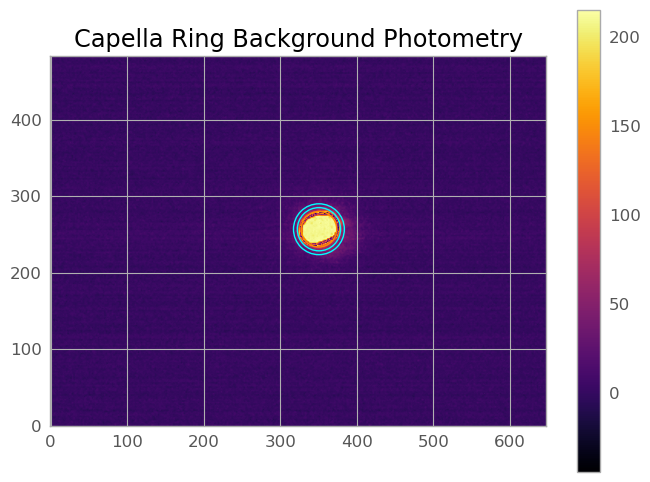

(4.8+/-0.7)e-14 W


In [17]:
capella_path = 'CCD-images/04-04-23/capella'
df2_path = 'CCD-images/04-04-23/df-2'

capella_flux_data = process_star_images(capella_path, df2_path, plot_title = 'Capella Ring Background Photometry')

capella_experimental_flux = ufloat(np.mean(capella_flux_data), np.std(capella_flux_data))
luminosity_capella = luminosity('Capella', capella_experimental_flux)
scaling_c = luminosity_capella[0] / luminosity_capella[1]
print(scaling_c)

In [18]:
print(f"Capella\nTheoretical luminosity (W): {luminosity_capella[0]}\nExperimental luminosity (W): {luminosity_capella[1]}\nScaling factor: {luminosity_capella[0] / luminosity_capella[1]}")

Capella
Theoretical luminosity (W): (3.01+/-0.16)e+28 W
Experimental luminosity (W): (6.3+/-0.8)e+41
Scaling factor: (4.8+/-0.7)e-14 W


### Algol

df:  42.81595133787369


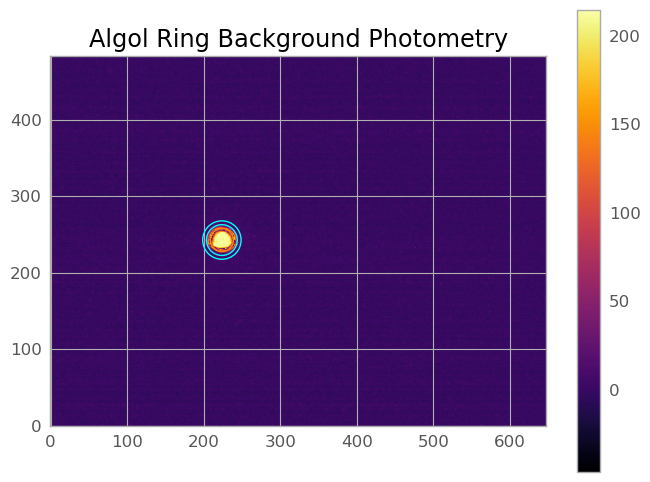

In [19]:
algol_path = 'CCD-images/04-04-23/algol'
df1_path = 'CCD-images/04-04-23/df-1'

algol_flux_data = process_star_images(algol_path, df1_path, 'Algol Ring Background Photometry')

algol_experimental_flux = ufloat(np.mean(algol_flux_data), np.std(algol_flux_data))
luminosity_algol = luminosity('Algol', algol_experimental_flux)
corrected_luminosity = luminosity_algol[1] * (luminosity_capella[0] / luminosity_capella[1])

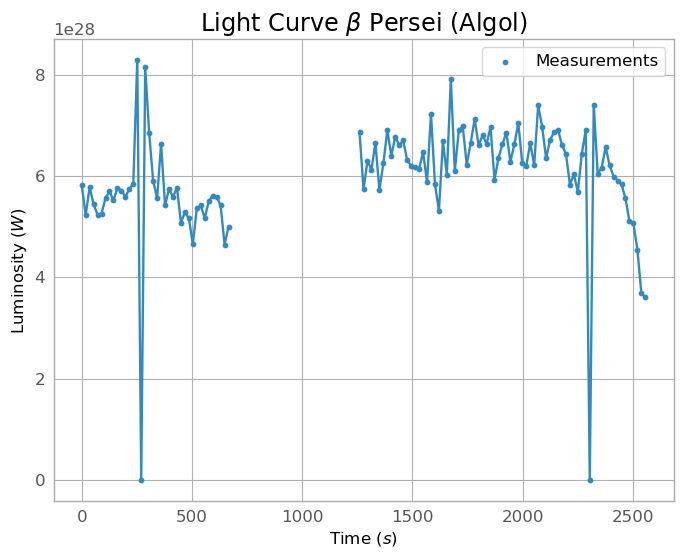

In [20]:
# Handling gap between the two measurement runs
gap = np.full(584 // 18, np.nan)
algol_flux_data_with_gap = np.concatenate([algol_flux_data[:38], gap, algol_flux_data[38:]])

luminosity_algol = luminosity('Algol', algol_flux_data_with_gap)[1]

plot_light_curve(unumpy.nominal_values(luminosity_algol), 18, r'Light Curve $\beta$ Persei (Algol)')

In [21]:
print(f"Algol:\nTheoretical luminosity (W): {luminosity_algol[0]}\nExperimental luminosity (W): {luminosity_algol[1]}\nScaled Experimental luminosity (W): {corrected_luminosity}")

Algol:
Theoretical luminosity (W): (1.213+/-0.026)e+42
Experimental luminosity (W): (1.088+/-0.023)e+42
Scaled Experimental luminosity (W): (6.0+/-1.4)e+28 W


In [22]:
outlier_indices = find_outliers(algol_flux_data)

for i in range(len(outlier_indices)):
    if outlier_indices[i] >= 38:
        outlier_indices[i] += 584 // 18
        
print(f"Outlier indices (using IQR): {outlier_indices}")

Outlier indices (using IQR): [ 14  15 128 141 142]


### Algol (without outliers)

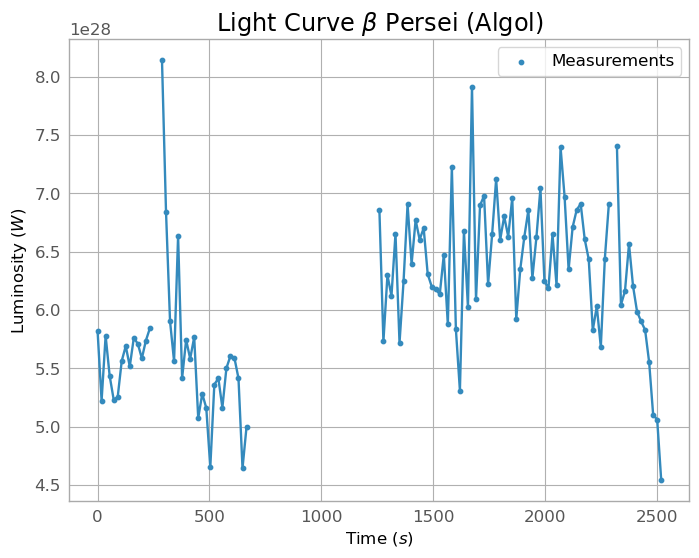

In [23]:
luminosity_algol = luminosity('Algol', algol_flux_data_with_gap)[1]

plot_light_curve(unumpy.nominal_values(luminosity_algol), 18, r'Light Curve $\beta$ Persei (Algol)', outliers = outlier_indices)

In [24]:
# Create a boolean mask for non-NaN values to avoid data processing issues
mask = ~np.isnan(algol_flux_data)

# Use the mask to select only non-NaN values
non_nan_data = algol_flux_data[mask]

print(type(np.mean(non_nan_data)))

algol_experimental_flux = ufloat(np.mean(non_nan_data), np.std(non_nan_data))
luminosity_algol = luminosity('Algol', algol_experimental_flux)
corrected_luminosity = luminosity_algol[1] * (luminosity_capella[0] / luminosity_capella[1])

<class 'numpy.float64'>


In [25]:
print(f"Algol:\nTheoretical luminosity (W): {luminosity_algol[0]}\nExperimental luminosity (W): {luminosity_algol[1]}\nScaled Experimental luminosity (W): {corrected_luminosity}")

Algol:
Theoretical luminosity (W): (6.97+/-0.08)e+28 W
Experimental luminosity (W): (1.25+/-0.24)e+42
Scaled Experimental luminosity (W): (6.0+/-1.4)e+28 W


### Algol (with interpolation)

The moving average suggest to replace the non-boundary outliers by:
[1.21594672e+42 1.10246697e+42 1.09083890e+42]


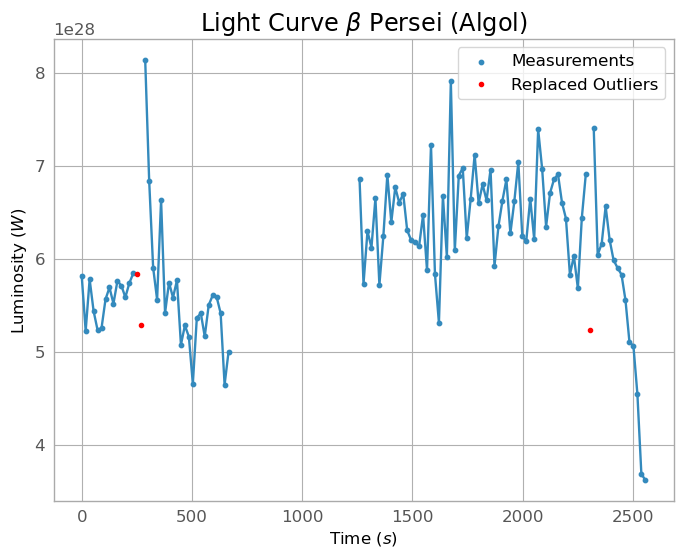

In [26]:
luminosity_algol = luminosity('Algol', algol_flux_data_with_gap)[1]

plot_light_curve(unumpy.nominal_values(luminosity_algol), 18, r'Light Curve $\beta$ Persei (Algol)', window_size = 5, replace_outliers = True, outliers = outlier_indices[0:3])

In [27]:
algol_flux_data_with_gap[14], algol_flux_data_with_gap[15], algol_flux_data_with_gap[128] = 123932.11656939, 112365.73581398, 111182.30203871

In [28]:
# Create a boolean mask for non-NaN values to avoid data processing issues
mask = ~np.isnan(algol_flux_data_with_gap)

# Use the mask to select only non-NaN values
non_nan_data = algol_flux_data_with_gap[mask]

algol_experimental_flux = ufloat(np.mean(non_nan_data), np.std(non_nan_data))
luminosity_algol = luminosity('Algol', algol_experimental_flux)
corrected_luminosity = luminosity_algol[1] * (luminosity_capella[0] / luminosity_capella[1])

In [29]:
print(f"Algol:\nTheoretical luminosity (W): {luminosity_algol[0]}\nExperimental luminosity (W): {luminosity_algol[1]}\nScaled Experimental luminosity (W): {corrected_luminosity}")

Algol:
Theoretical luminosity (W): (6.97+/-0.08)e+28 W
Experimental luminosity (W): (1.26+/-0.16)e+42
Scaled Experimental luminosity (W): (6.0+/-1.1)e+28 W


In [30]:
print(f"Algol:\nPercent error (%): {(((luminosity_algol[1]*(luminosity_capella[0] / luminosity_capella[1]))-luminosity_algol[0])/luminosity_algol[0])*100}")

Algol:
Percent error (%): -13+/-16


### Theoretical data Algol

In [31]:
theoretical_algol = get_algol_data()
theoretical_algol[0:5] # head of the data

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
2882.334709312126,1.7110262e+07,4.4552332e+02,4.9529420e-03,1191510,1085.32216,1597.27131,1.7056062e+07,4.3950815e+02,4.0314379e+04,4.5713600e+01,1.7110262e+07,4.4552332e+02,0,———,———,———,———,1085.32216,3.1103889e-05,1597.27131,2.7891996e-04,3.3778645e-02,-8.6339675e-02
2882.33609824274,1.7104506e+07,4.4551883e+02,4.9529844e-03,1191511,1085.32258,1597.27325,1.7055356e+07,4.3950372e+02,4.0352332e+04,4.5754356e+01,1.7104506e+07,4.4551883e+02,0,———,———,———,———,1085.32258,3.1106229e-05,1597.27325,2.7885492e-04,3.3606008e-02,-8.0429085e-02
2882.337487172888,1.7123258e+07,4.4580811e+02,4.9530263e-03,1191512,1085.31903,1597.27909,1.7078000e+07,4.3978909e+02,4.0323207e+04,4.5742981e+01,1.7123258e+07,4.4580811e+02,0,———,———,———,———,1085.31903,3.1083451e-05,1597.27909,2.7922410e-04,2.8799294e-02,-7.6035693e-02
2882.3388761035017,1.7116906e+07,4.4569064e+02,4.9530687e-03,1191513,1085.32074,1597.27320,1.7068334e+07,4.3967322e+02,4.0380289e+04,4.5806393e+01,1.7116906e+07,4.4569064e+02,0,———,———,———,———,1085.32074,3.1093557e-05,1597.27320,2.7908376e-04,3.1137787e-02,-7.9122379e-02
2882.3402650341163,1.7113118e+07,4.4574307e+02,4.9531111e-03,1191514,1085.32004,1597.27676,1.7072826e+07,4.3972491e+02,4.0272223e+04,4.5741863e+01,1.7113118e+07,4.4574307e+02,0,———,———,———,———,1085.32004,3.1090658e-05,1597.27676,2.7906973e-04,3.0257845e-02,-7.5564623e-02


In [32]:
# Setting up the observation parameters
rotation_period = 2 + (20 * 60 + 49) / (24 * 60)
observing_time = Time('2023-04-04 20:53')
start_date_TESS = Time('2022-10-29 20:00')

# Computing the complete rotation time and various phase shifts
complete_rotations = get_complete_rotations(theoretical_algol, rotation_period, observing_time, start_date_TESS)
phase = get_phase(theoretical_algol, observing_time, complete_rotations, rotation_period)
phase_min_flux = get_phase_from_minimum_flux(theoretical_algol, observing_time, complete_rotations, rotation_period)

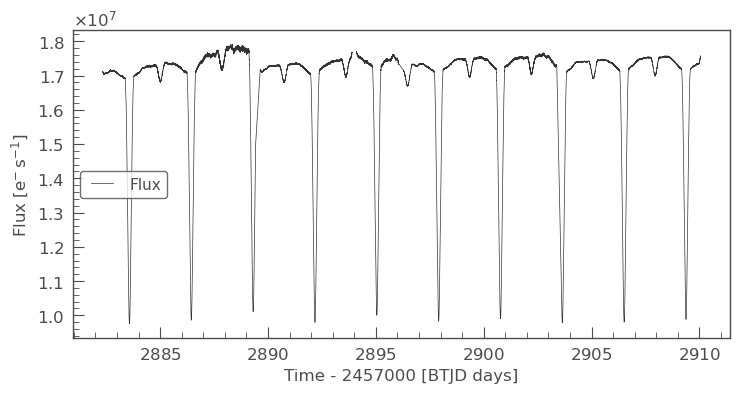

In [33]:
# Inline plot to get a better intuition of the data
ax = theoretical_algol.plot(column='flux', label='Flux')

In [34]:
theoretical_flux = unumpy.uarray(np.asarray(theoretical_algol['flux']), np.asarray(theoretical_algol['flux_err'])) #warning here

flux_tess_mean = np.nanmax(theoretical_flux)

L_sun_m = 3.846*10**26
Lum_algol = 182*L_sun_m

scaling_factor = Lum_algol/flux_tess_mean

luminosity_tess = theoretical_flux * scaling_factor

C:\Users\yaeld\anaconda3\lib\site-packages\numpy\lib\function_base.py:2411: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


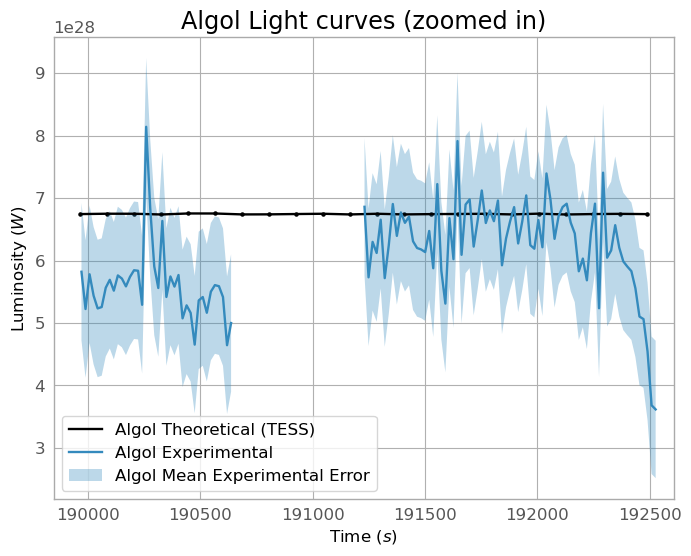

Average TESS luminosity over region of interest:  6.754362083092498e+28


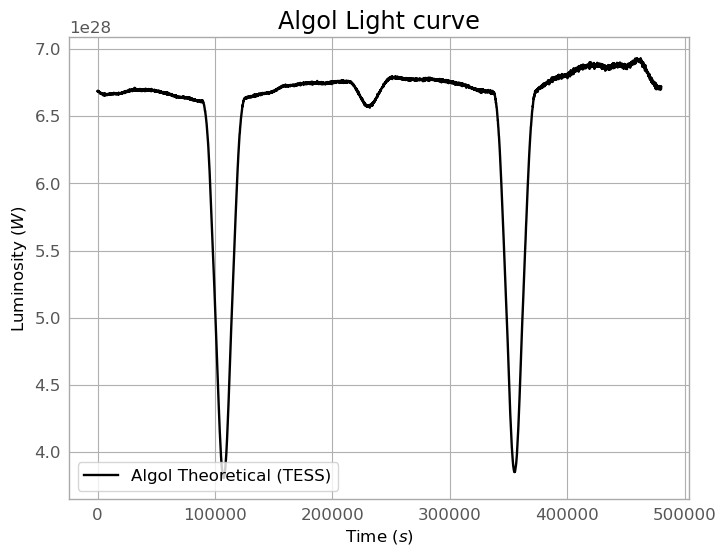

In [39]:
# Once we have the required TESS data we can plot our juxtaposition of data
num_points = len(algol_flux_data_with_gap)
measurement_time = np.arange(0, 18 * num_points, 18) + 189970.3010827411
luminosity_algol = luminosity('Algol', algol_flux_data_with_gap)[1]

time_tess = theoretical_algol['time']

time_in_days = time_tess - time_tess[0]
time = time_in_days.replicate(format = 'sec')
time = time.value

plt.scatter(time[1583:1605], unumpy.nominal_values(luminosity_tess)[1583:1605], s=5, color='black')
plt.plot(time[1583:1605], unumpy.nominal_values(luminosity_tess)[1583:1605], color='black', label = 'Algol Theoretical (TESS)')
plt.plot(measurement_time, unumpy.nominal_values(luminosity_algol)* (4.8 * 10 ** -14), label = 'Algol Experimental')
plt.fill_between(measurement_time, 
                      unumpy.nominal_values(luminosity_algol)* (4.8 * 10 ** -14)+1.1*10**28, 
                      unumpy.nominal_values(luminosity_algol)* (4.8 * 10 ** -14)-1.1*10**28, alpha=0.33, label = 'Algol Mean Experimental Error')
plt.xlabel(r"Time $(s)$")
plt.ylabel(r"Luminosity $(W)$")
plt.title('Algol Light curves (zoomed in)')
plt.xlim(time[1582], time[1605])
plt.legend(loc='lower left')
plt.show()

print('Average TESS luminosity over region of interest: ', np.nanmax(unumpy.nominal_values(luminosity_tess)[1582:1604]))

plt.plot(time[0:4000], unumpy.nominal_values(luminosity_tess)[0:4000], color='black', label = 'Algol Theoretical (TESS)')
plt.xlabel(r"Time $(s)$")
plt.ylabel(r"Luminosity $(W)$")
plt.title('Algol Light curve')
plt.legend(loc='lower left')
plt.show()

In [36]:
# Checking 2/3 rule
count = 0
length = 0

mean_theoretical = np.nanmax(unumpy.nominal_values(luminosity_tess)[1582:1604])

for i in luminosity_algol:
    if i * (4.8 * 10 ** -14) + 1.1 * 10 ** 28 >= mean_theoretical and i * (4.8 * 10 ** -14) - 1.1 * 10 ** 28 <= mean_theoretical:
        count+=1


In [37]:
print('Percentage of data points agreeing with the expected mean: ', 100*count / np.count_nonzero(~np.isnan(unumpy.nominal_values(luminosity_algol))))

Percentage of data points agreeing with the expected mean:  69.36936936936937
